In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OrdinalEncoder
from io import StringIO
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lazypredict.Supervised import LazyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
features = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\Features_data_set.csv')
sales = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\sales_data_set.csv')
stores = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\stores_data_set.csv')

In [4]:
sales['Date'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y')
features['Date'] = pd.to_datetime(features['Date'], format='%d/%m/%Y')

In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [96]:
percentage_null_CPI = (features['CPI'].isnull().sum() / len(features['CPI'])) * 100
percentage_null_Unemployment = (features['Unemployment'].isnull().sum() / len(features['Unemployment'])) * 100
print("__Percentage Of Null Values__")
[print(f"percentage_null_MarkDown{i} : {(features[f'MarkDown{i}'].isnull().sum() / len(features[f'MarkDown{i}'])) * 100}") for i in range(1, 6)]
print("percentage_of_CPI :", percentage_null_CPI)
print("percentage_of_Unemployment :", percentage_null_Unemployment)

__Percentage Of Null Values__
percentage_null_MarkDown1 : 50.76923076923077
percentage_null_MarkDown2 : 64.33455433455434
percentage_null_MarkDown3 : 55.885225885225886
percentage_null_MarkDown4 : 57.7045177045177
percentage_null_MarkDown5 : 50.54945054945055
percentage_of_CPI : 7.142857142857142
percentage_of_Unemployment : 7.142857142857142


In [94]:
fig = px.pie(stores, names='Type', title='Pie Chart of Store Types', hole=0.3)
fig.show()

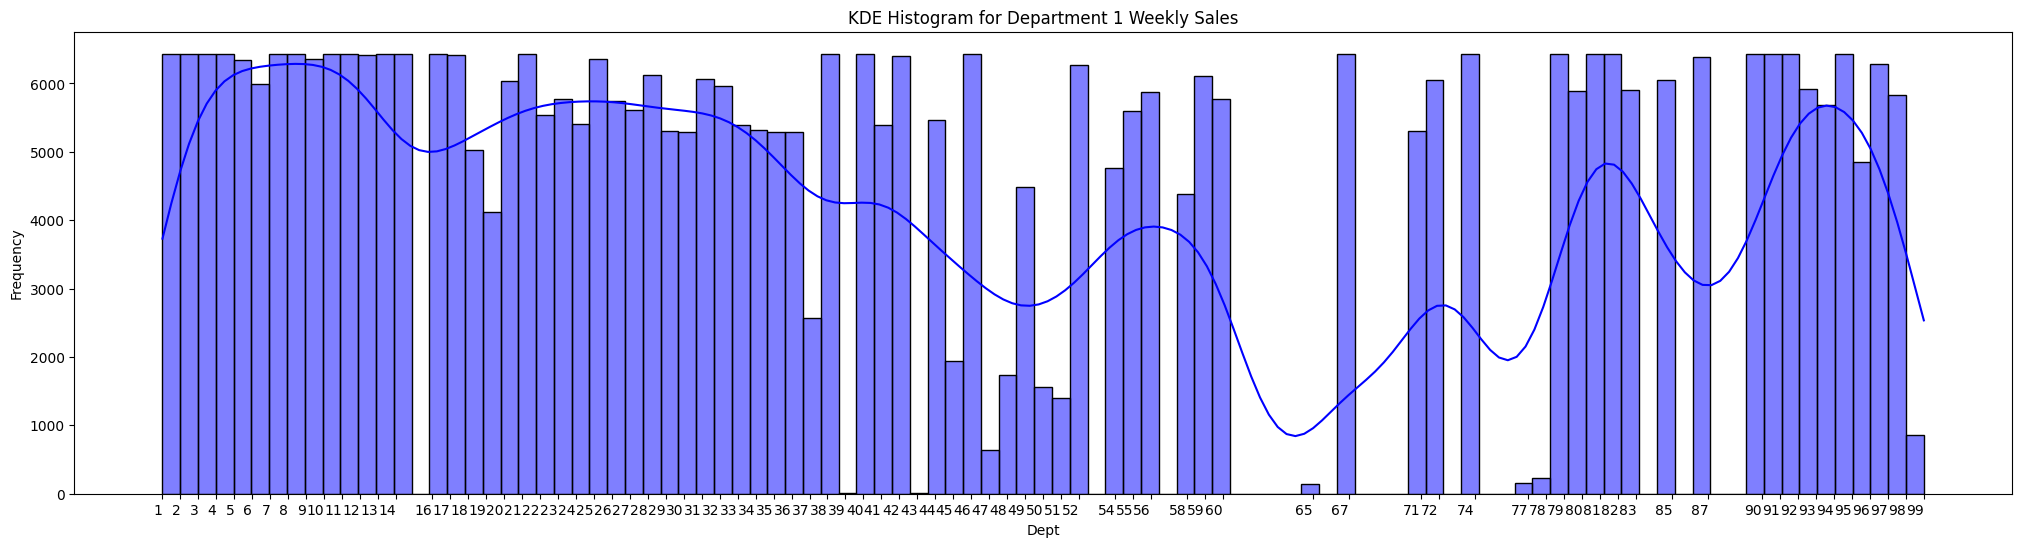

In [8]:
plt.figure(figsize=(25, 6))
sns.histplot(sales['Dept'], kde=True, color='blue', bins=99)
plt.title('KDE Histogram for Department 1 Weekly Sales')
plt.xlabel('Dept')
plt.ylabel('Frequency')
plt.xticks(sales['Dept'].unique(), ha="right")
plt.show()

In [98]:
column_names = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
statistics_features = features[column_names].describe().T
statistics_features['negative values'] = [features[col][features[col] < 0].count() for col in column_names]
statistics_features['null values'] = [features[col].isnull().sum() for col in column_names]
statistics_features['percentage of null values'] = [(features[col].isnull().sum() / len(features[col])) * 100 for col in column_names]
statistics_features = statistics_features.T
statistics_features

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
count,4032.00,2921.00,3613.00,3464.00,4050.00
mean,7032.37,3384.18,1760.10,3292.94,4132.22
std,9262.75,8793.58,11276.46,6792.33,13086.69
min,-2781.45,-265.76,-179.26,0.22,-185.17
25%,1577.53,68.88,6.60,304.69,1440.83
50%,4743.58,364.57,36.26,1176.42,2727.14
75%,8923.31,2153.35,163.15,3310.01,4832.56
max,103184.98,104519.54,149483.31,67474.85,771448.10
negative values,4.00,25.00,13.00,0.00,2.00
null values,4158.00,5269.00,4577.00,4726.00,4140.00


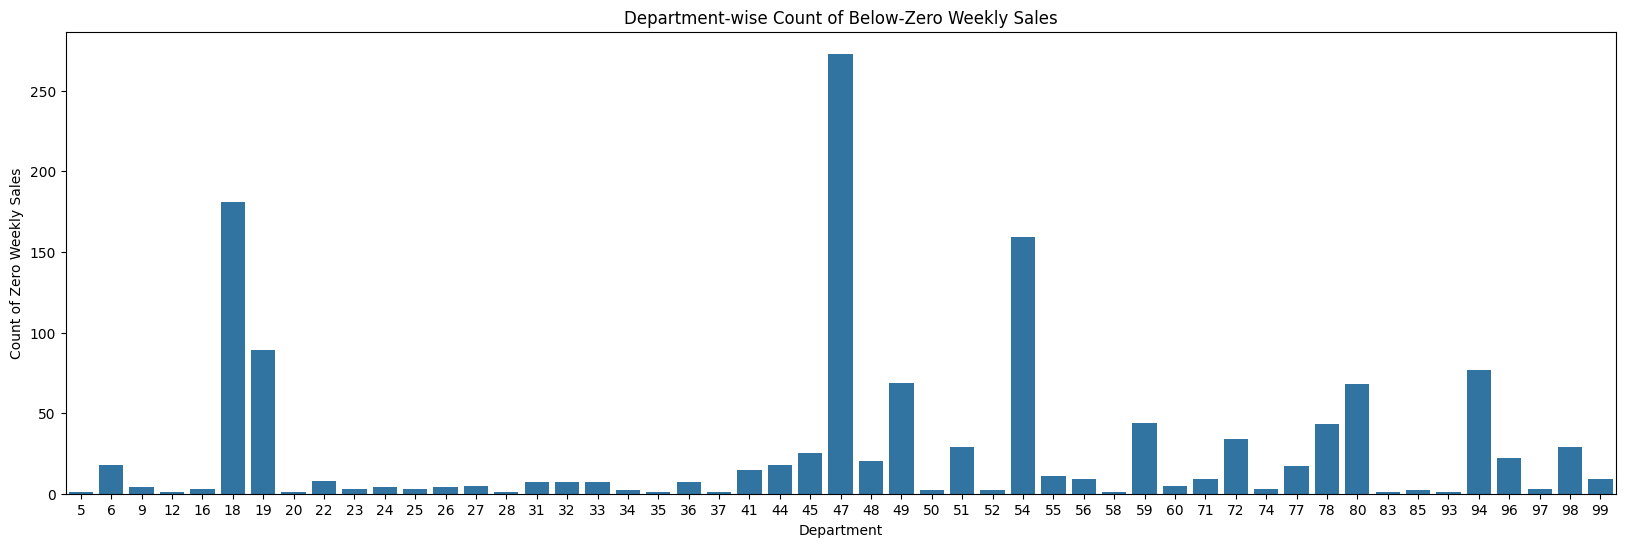

In [105]:
below_zero_sales_by_department = sales[sales['Weekly_Sales'] <= 0].groupby('Dept').size().reset_index(name='Zero_Sales_Count')
plt.figure(figsize=(20, 6))
sns.barplot(x='Dept', y='Zero_Sales_Count', data=below_zero_sales_by_department)
plt.xlabel('Department')
plt.ylabel('Count of Zero Weekly Sales')
plt.title('Department-wise Count of Below-Zero Weekly Sales')
plt.show()

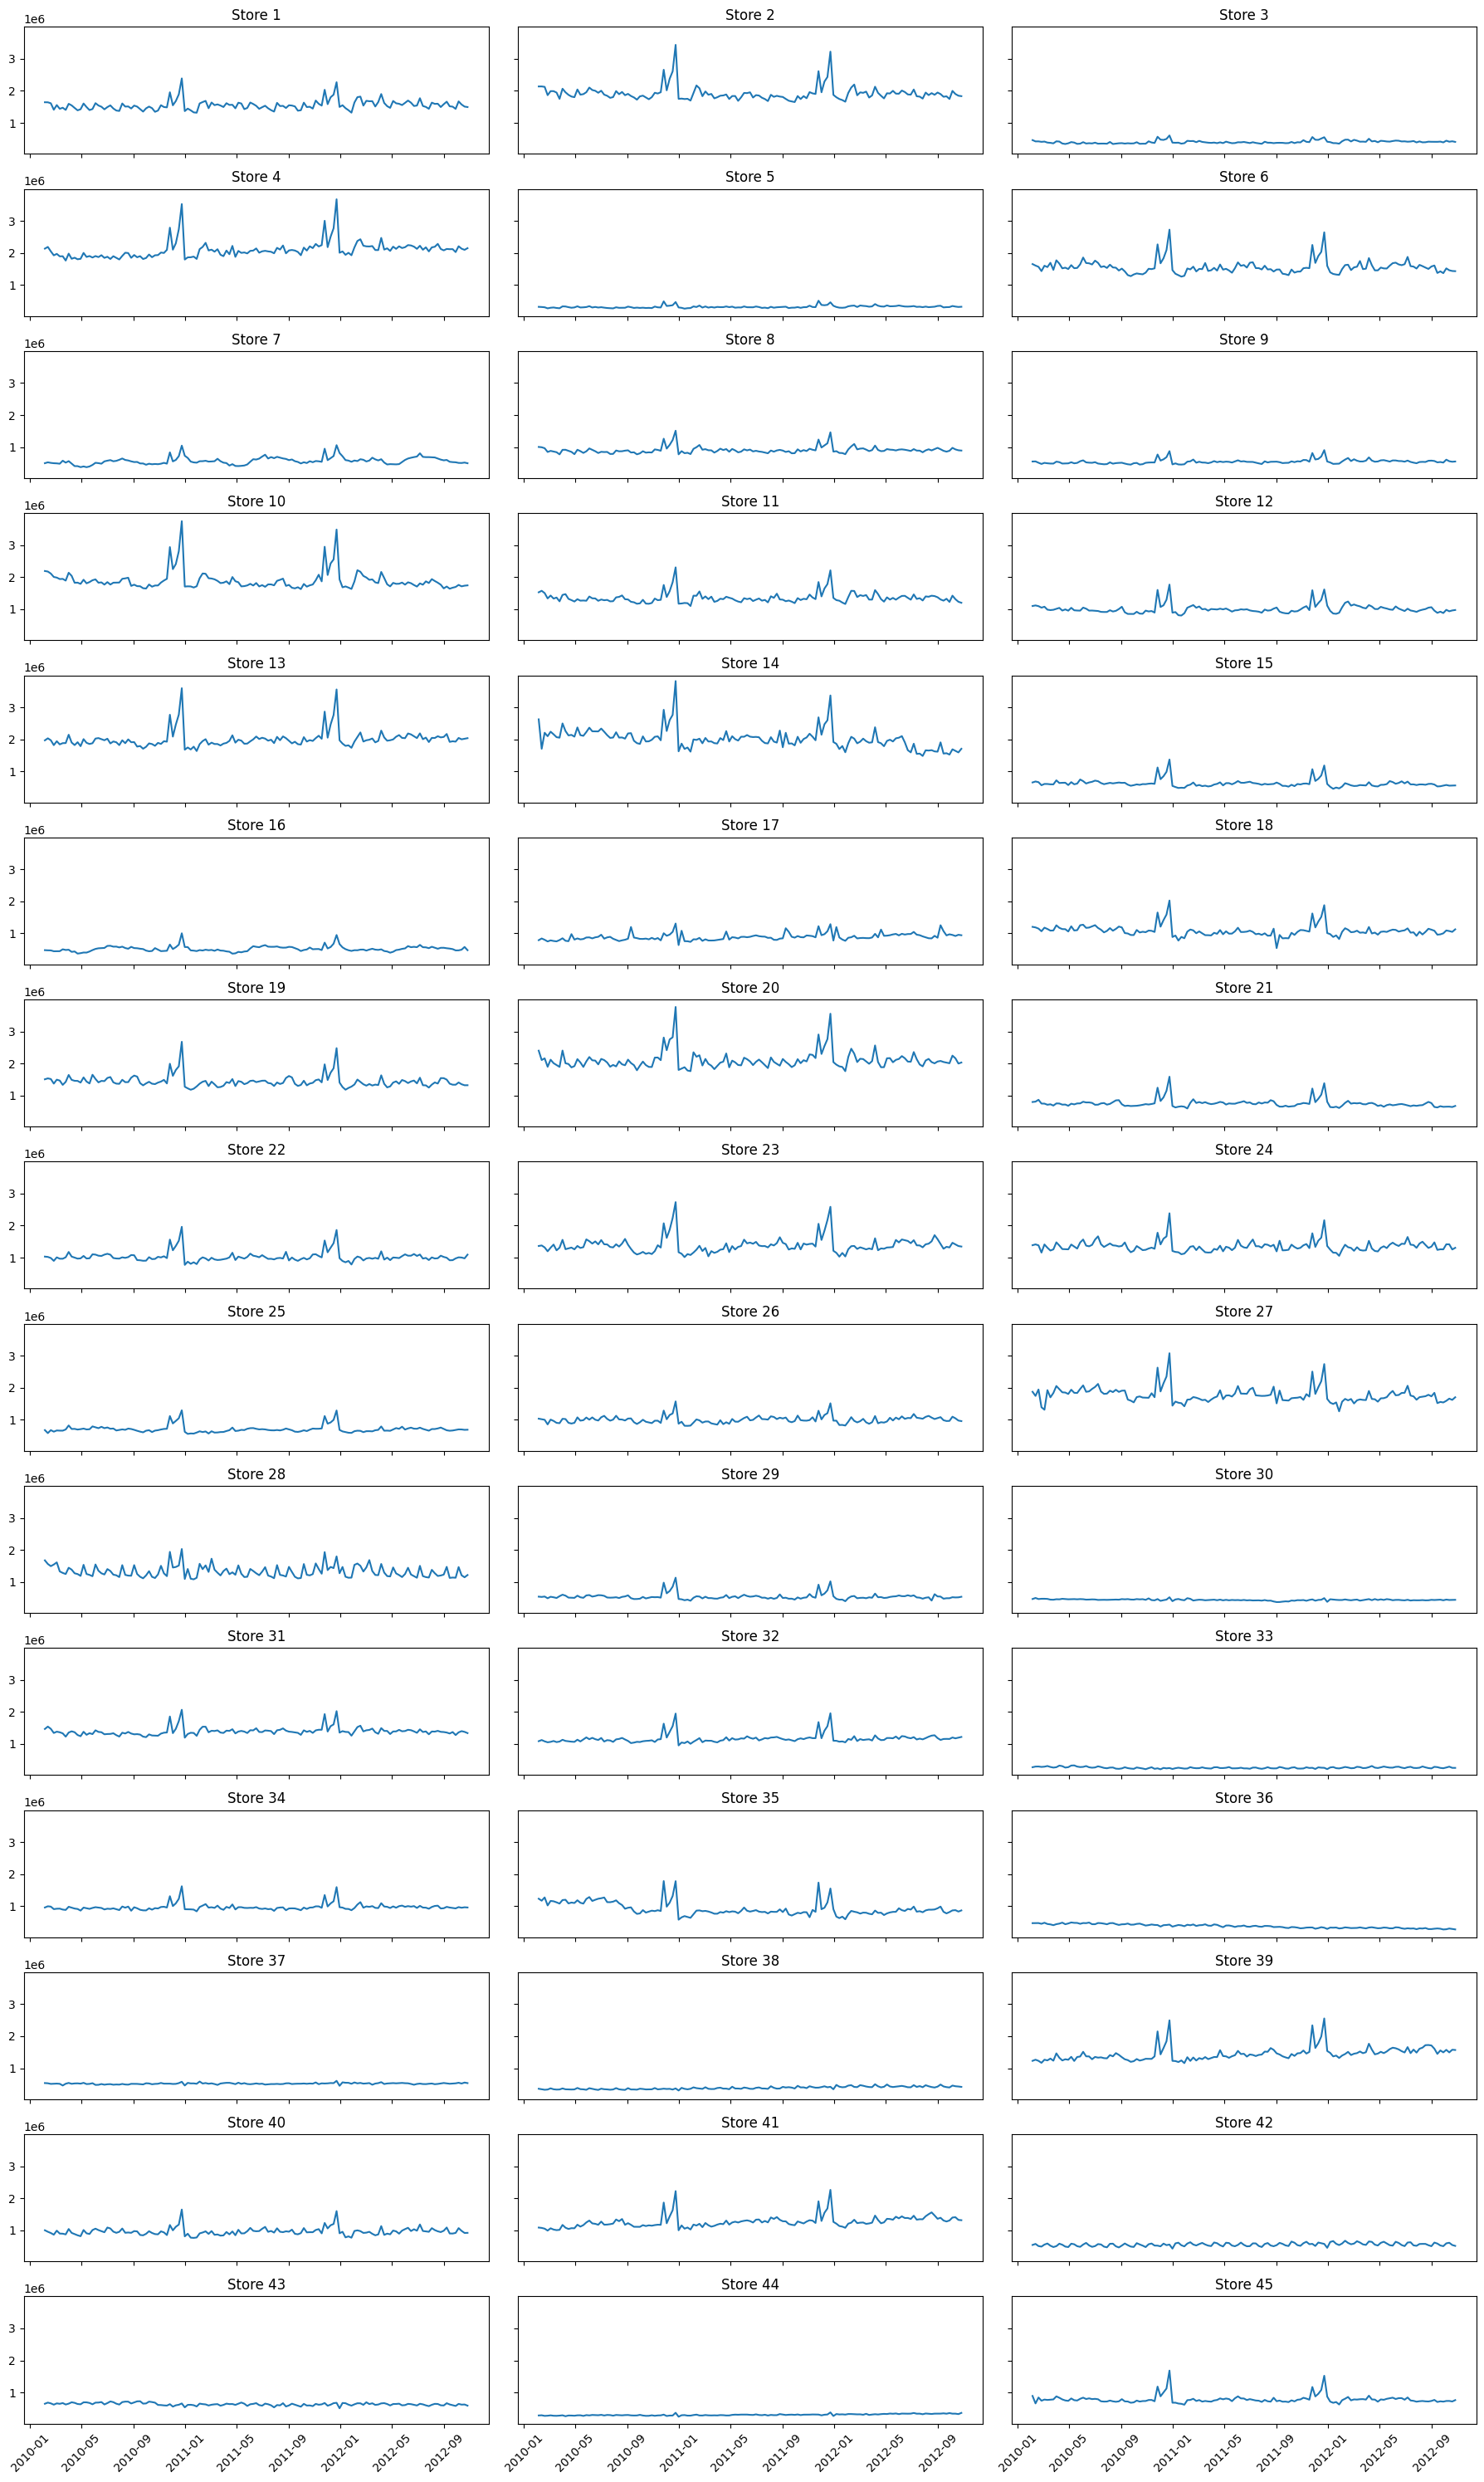

In [107]:
store_numbers = range(1, 46)
fig, axes = plt.subplots(nrows=15, ncols=3, figsize=(18, 30), sharex=True, sharey=True)
axes = axes.flatten()
for i, store_num in enumerate(store_numbers):
    store_data = sales[sales['Store'] == store_num]

    weekly_sales = store_data.groupby('Date')['Weekly_Sales'].sum()

    axes[i].plot(weekly_sales.index, weekly_sales, label=f'Store {store_num}')
    axes[i].set_title(f'Store {store_num}')

    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [110]:
features_cp = features.copy(deep=True)

In [111]:
features_cp['month'] = features_cp['Date'].dt.month
features_cp['year'] = features_cp['Date'].dt.year

In [113]:
features_cp = sales.merge(features_cp,how="left", on=['Store', 'Date', 'IsHoliday'])

Text(0, 0.5, 'Sales')

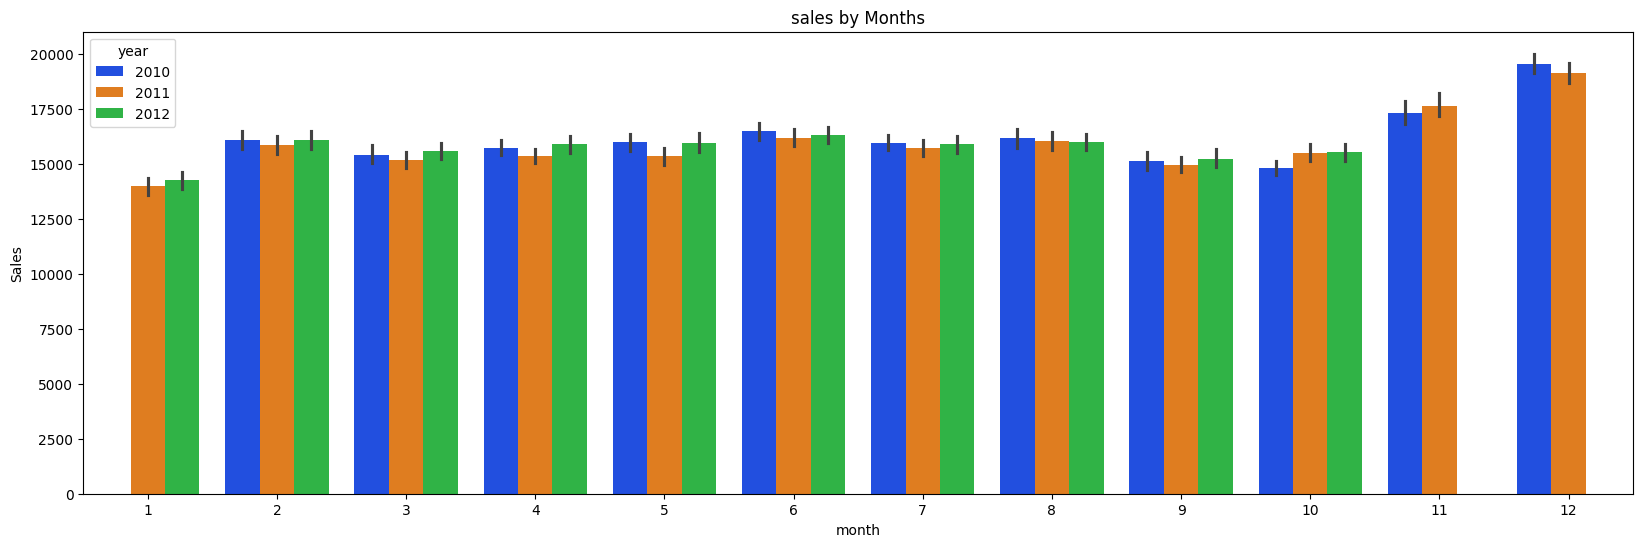

In [116]:
plt.figure(figsize=(20, 6))
sns.barplot(data=features_cp,x='month',y='Weekly_Sales',hue='year',palette='bright').set_title('sales by Months')
plt.ylabel('Sales')

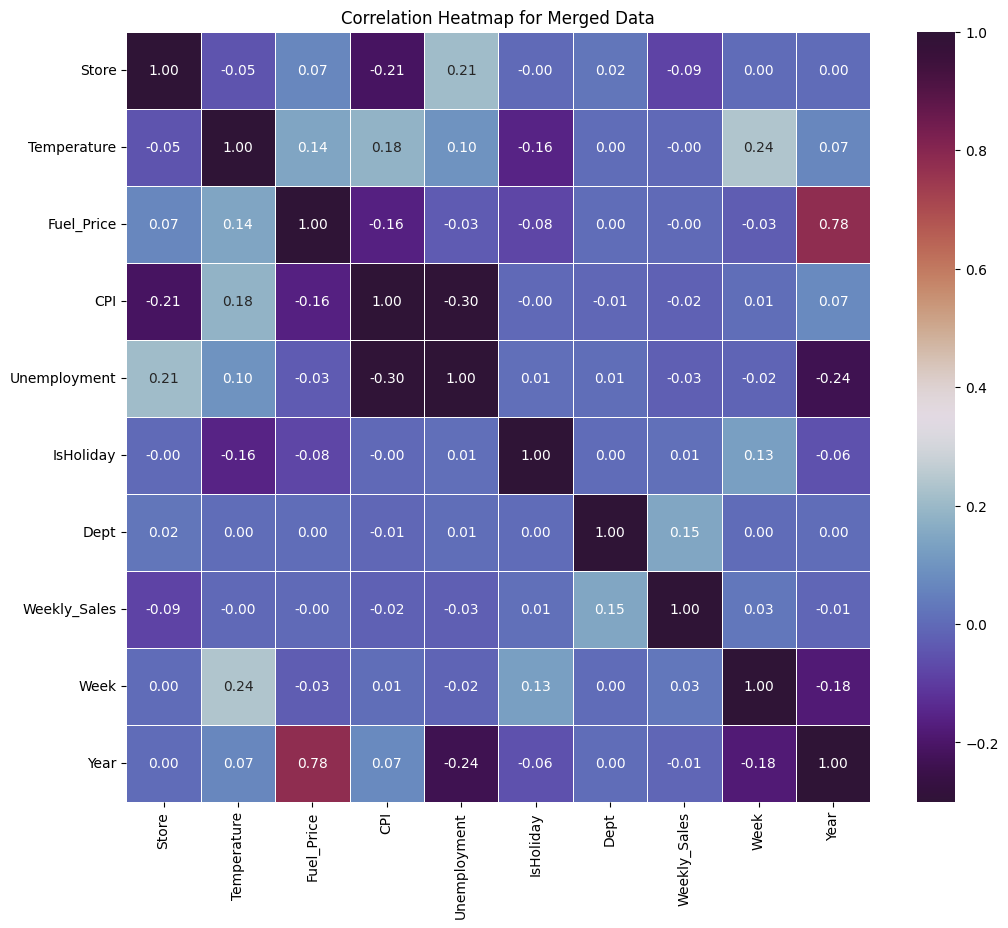

In [108]:
corr_matrix = merged_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='twilight_shifted', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Merged Data')
plt.show()

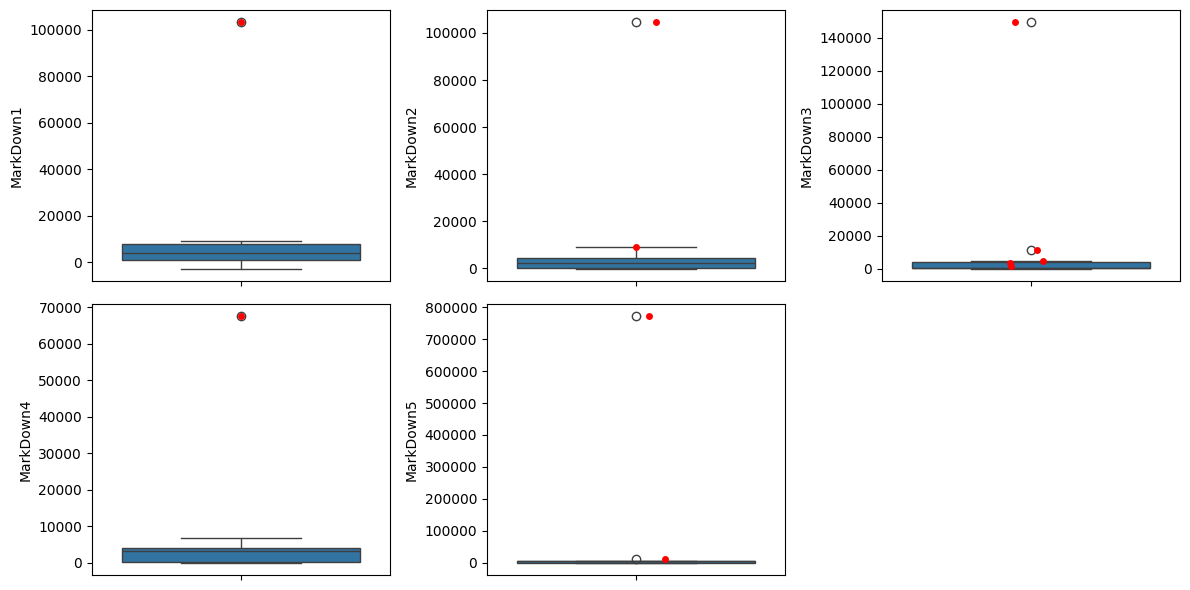

In [99]:
columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

plt.figure(figsize=(12, 6))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)

    sns.boxplot(data=statistics_features, y=col)

    Q1 = statistics_features[col]['25%']
    Q3 = statistics_features[col]['75%']
    IQR = Q3 - Q1 # Inter quartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (statistics_features[col] < lower_bound) | (statistics_features[col] > upper_bound)  # 5 number summary

    sns.stripplot(data=statistics_features[outliers], y=col, color='red', jitter=True, size=5)

plt.tight_layout()
plt.show()

In [95]:
print('Stores :', sales[sales['Dept'] == 39]['Store'].unique())
print('Dept   :', sales[sales['Store']==39]['Dept'].unique())

Stores : [ 2  4 18 19 27]
Dept   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 38 40 41 42 44 45 46 47 49 51 52 54 55
 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94 95 96
 97 98 99]


In [9]:
merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])

In [10]:
merged_data = merged_data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)

In [11]:
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
merged_data['Year'] = merged_data['Date'].dt.year

In [12]:
merged_data.drop('Date', axis=1, inplace=True)

In [13]:
merged_data

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Week,Year
0,1,42.31,2.572,211.096358,8.106,False,1,24924.50,5,2010
1,1,42.31,2.572,211.096358,8.106,False,2,50605.27,5,2010
2,1,42.31,2.572,211.096358,8.106,False,3,13740.12,5,2010
3,1,42.31,2.572,211.096358,8.106,False,4,39954.04,5,2010
4,1,42.31,2.572,211.096358,8.106,False,5,32229.38,5,2010
...,...,...,...,...,...,...,...,...,...,...
421565,45,58.85,3.882,192.308899,8.667,False,93,2487.80,43,2012
421566,45,58.85,3.882,192.308899,8.667,False,94,5203.31,43,2012
421567,45,58.85,3.882,192.308899,8.667,False,95,56017.47,43,2012
421568,45,58.85,3.882,192.308899,8.667,False,97,6817.48,43,2012


In [66]:
focused_data = merged_data[merged_data['Store'] == 1]

In [67]:
focused_data

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Week,Year
0,1,42.31,2.572,211.096358,8.106,False,1,24924.50,5,2010
1,1,42.31,2.572,211.096358,8.106,False,2,50605.27,5,2010
2,1,42.31,2.572,211.096358,8.106,False,3,13740.12,5,2010
3,1,42.31,2.572,211.096358,8.106,False,4,39954.04,5,2010
4,1,42.31,2.572,211.096358,8.106,False,5,32229.38,5,2010
...,...,...,...,...,...,...,...,...,...,...
10239,1,69.16,3.506,223.444251,6.573,False,94,60278.73,43,2012
10240,1,69.16,3.506,223.444251,6.573,False,95,117375.38,43,2012
10241,1,69.16,3.506,223.444251,6.573,False,96,36851.92,43,2012
10242,1,69.16,3.506,223.444251,6.573,False,97,32830.52,43,2012


<Axes: >

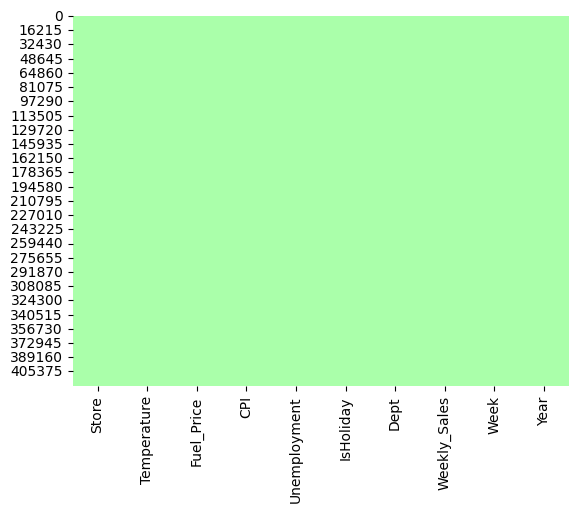

In [61]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [46]:
merged_data.set_index('Date', inplace=True)

In [14]:
encoder = OrdinalEncoder()
merged_data['IsHoliday'] = encoder.fit_transform(merged_data[['IsHoliday']])

In [19]:
X = merged_data.drop('Weekly_Sales', axis=1)
y = merged_data['Weekly_Sales']

In [25]:
X.columns.unique()

Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Dept', 'Week', 'Year'],
      dtype='object')

In [21]:
X.shape, y.shape

((421570, 9), (421570,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
LR = LazyRegressor(verbose=0, ignore_warnings=False)
models, predictions = LR.fit(x_train, x_test, y_train, y_test)

In [117]:
data = """
Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken
ExtraTreesRegressor,0.96,0.96,4630.90,177.48
RandomForestRegressor,0.93,0.93,5736.59,397.72
BaggingRegressor,0.93,0.93,5793.68,40.08
XGBRegressor,0.92,0.92,6225.55,1.51
LGBMRegressor,0.87,0.87,7831.10,0.93
HistGradientBoostingRegressor,0.87,0.87,7967.84,2.23
DecisionTreeRegressor,0.85,0.85,8368.61,5.27
ExtraTreeRegressor,0.83,0.83,9021.75,1.94
GradientBoostingRegressor,0.64,0.64,13195.39,35.01
KNeighborsRegressor,0.32,0.32,18135.77,9.17
MLPRegressor,0.15,0.15,20240.41,282.81
AdaBoostRegressor,0.04,0.04,21504.97,17.80
SGDRegressor,0.03,0.03,21585.19,2.08
Lasso,0.03,0.03,21586.97,0.36
LassoLars,0.03,0.03,21586.98,0.20
BayesianRidge,0.03,0.03,21587.00,0.30
RidgeCV,0.03,0.03,21587.01,0.38
Ridge,0.03,0.03,21587.01,0.20
LassoLarsIC,0.03,0.03,21587.01,0.33
LinearRegression,0.03,0.03,21587.01,0.23
TransformedTargetRegressor,0.03,0.03,21587.01,0.35
Lars,0.03,0.03,21587.01,0.27
LassoCV,0.03,0.03,21589.19,1.71
OrthogonalMatchingPursuitCV,0.03,0.03,21589.21,0.56
LassoLarsCV,0.03,0.03,21589.37,0.79
LarsCV,0.03,0.03,21589.37,0.85
ElasticNet,0.03,0.03,21632.86,0.23
OrthogonalMatchingPursuit,0.03,0.03,21688.29,0.21
TweedieRegressor,0.03,0.03,21688.34,0.34
ElasticNetCV,0.01,0.01,21819.44,1.55
DummyRegressor,-0.00,-0.00,21970.69,0.16
NuSVR,-0.03,-0.03,22312.51,13611.17
RANSACRegressor,-0.04,-0.04,22354.21,1.15
HuberRegressor,-0.08,-0.08,22784.61,0.89
SVR,-0.12,-0.12,23216.95,8694.55
PassiveAggressiveRegressor,-0.14,-0.14,23503.68,0.62
LinearSVR,-0.15,-0.15,23577.14,0.52
"""

df = pd.read_csv(StringIO(data), index_col='Model')

df

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.96,0.96,4630.90,177.48
RandomForestRegressor,0.93,0.93,5736.59,397.72
BaggingRegressor,0.93,0.93,5793.68,40.08
XGBRegressor,0.92,0.92,6225.55,1.51
LGBMRegressor,0.87,0.87,7831.10,0.93
HistGradientBoostingRegressor,0.87,0.87,7967.84,2.23
DecisionTreeRegressor,0.85,0.85,8368.61,5.27
ExtraTreeRegressor,0.83,0.83,9021.75,1.94
GradientBoostingRegressor,0.64,0.64,13195.39,35.01


In [30]:
extra_trees_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

In [33]:
extra_trees_model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [34]:
y_pred = extra_trees_model.predict(X_test)

In [35]:
r2 = r2_score(y_test, y_pred)


In [37]:
r2

0.9655659224453282

In [40]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [41]:
rmse

4254.745433438719

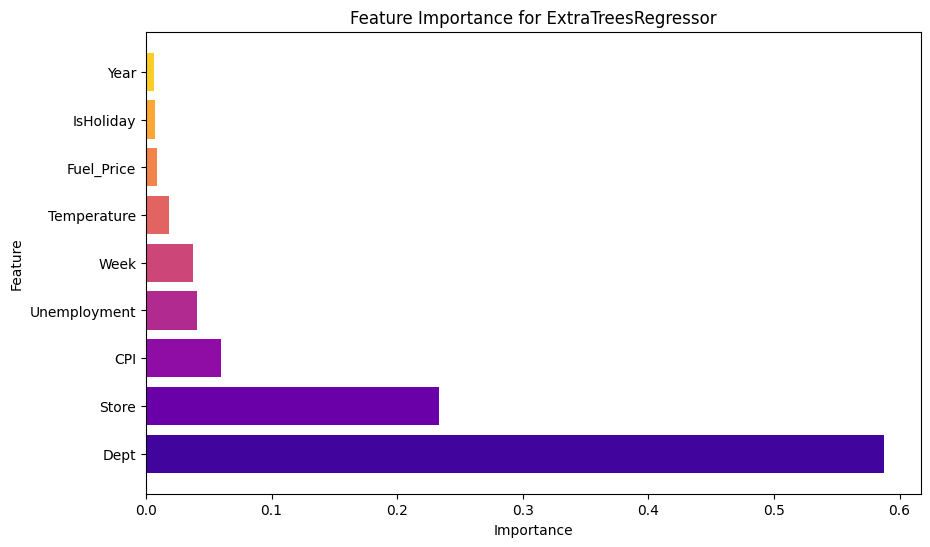

In [46]:
feature_importances = extra_trees_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

colors = sns.color_palette("plasma", n_colors=len(sorted_indices))

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances[sorted_indices], color=colors)
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for ExtraTreesRegressor")
plt.show()

In [67]:
new_merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])

In [68]:
holidays = new_merged_data[new_merged_data['IsHoliday']==1]

<Axes: >

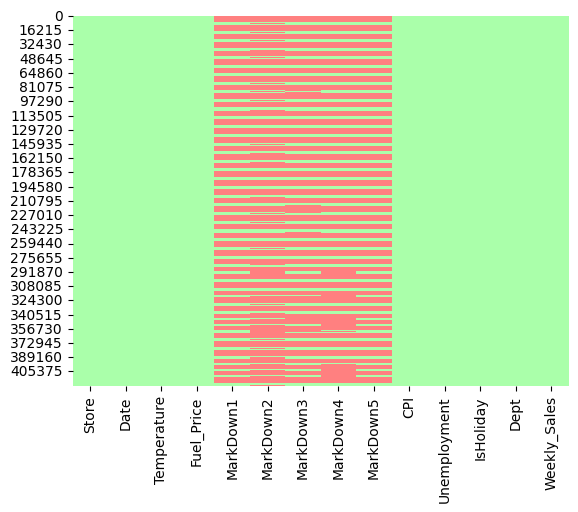

In [69]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(new_merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [70]:
new_merged_data["MarkDown1"].fillna(0, inplace=True)
new_merged_data["MarkDown2"].fillna(0, inplace=True)
new_merged_data["MarkDown3"].fillna(0, inplace=True)
new_merged_data["MarkDown4"].fillna(0, inplace=True)
new_merged_data["MarkDown5"].fillna(0, inplace=True)

<Axes: >

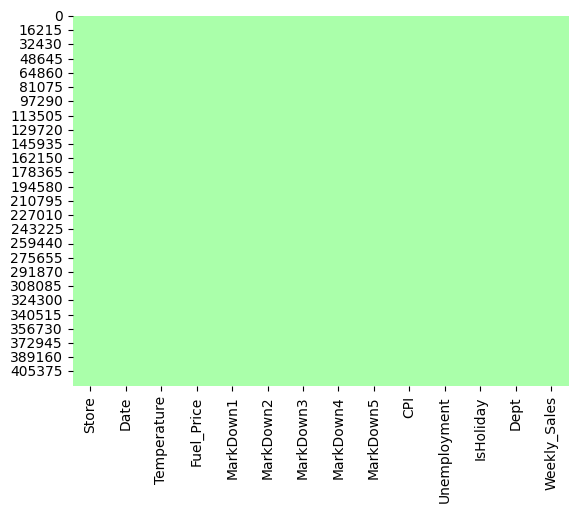

In [71]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(new_merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [72]:
new_merged_data.drop(['Store','Temperature','Date','Fuel_Price','CPI','Unemployment','Dept','Weekly_Sales'], axis=1, inplace=True)

In [74]:
encoder = OrdinalEncoder()
new_merged_data['IsHoliday'] = encoder.fit_transform(new_merged_data[['IsHoliday']])

In [75]:
new_merged_data

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday
0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...
421565,4018.91,58.08,100.00,211.94,858.33,0.00
421566,4018.91,58.08,100.00,211.94,858.33,0.00
421567,4018.91,58.08,100.00,211.94,858.33,0.00
421568,4018.91,58.08,100.00,211.94,858.33,0.00


In [76]:
X = new_merged_data.drop("IsHoliday", axis=1)
y = new_merged_data["IsHoliday"]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [19:55<02:26, 146.31s/it]

[LightGBM] [Info] Number of positive: 23525, number of negative: 313731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069754 -> initscore=-2.590472
[LightGBM] [Info] Start training from score -2.590472


100%|██████████| 29/29 [19:56<00:00, 41.26s/it] 


In [81]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.70,0.70,0.95,1.06
KNeighborsClassifier,0.96,0.70,0.70,0.95,169.69
XGBClassifier,0.96,0.70,0.70,0.95,0.98
RandomForestClassifier,0.96,0.70,0.70,0.95,20.38
DecisionTreeClassifier,0.96,0.70,0.70,0.95,0.59
BaggingClassifier,0.96,0.70,0.70,0.95,3.75
ExtraTreeClassifier,0.96,0.70,0.70,0.95,0.34
ExtraTreesClassifier,0.96,0.70,0.70,0.95,15.64
SVC,0.94,0.62,0.62,0.93,897.34


In [84]:
dt_classifier = DecisionTreeClassifier(random_state=42)

In [85]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [86]:
y_pred = dt_classifier.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9566738619920773

In [88]:
feature_importances = dt_classifier.feature_importances_

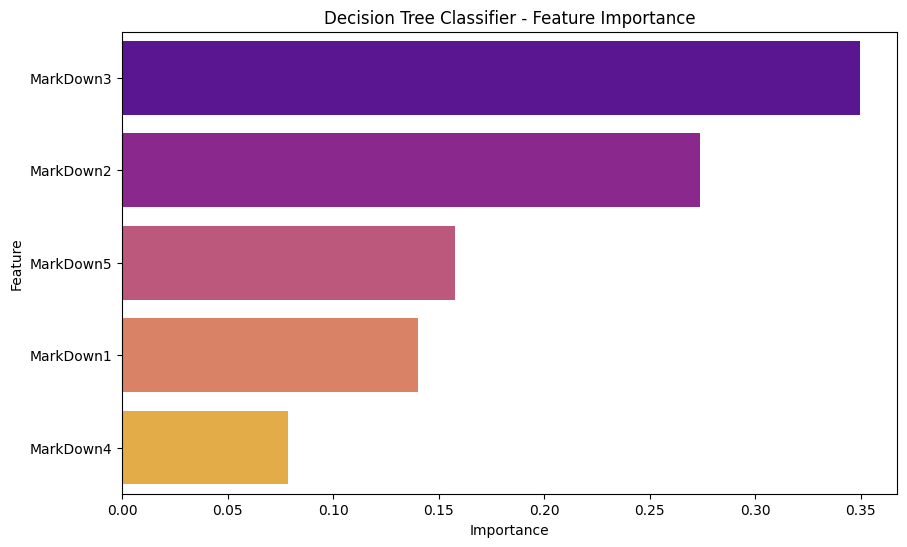

In [90]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='plasma')
plt.title('Decision Tree Classifier - Feature Importance')
plt.show()